# ARIMA model technical write up

## What is ARIMA?

ARIMA is a type of model for times series modelling for univariate data. It uses past values and forecast errors to predict future values

It's made up of 3 parts:

* **AR** which stands for Auto-Regressive
* **I** which stands for Integrated
* **MA** which stands for Moving Average

### What is Auto-Regressive?

This is the part of the model which does the predicting part using linear regression. Because the prediction is done using the past values to predict the future values, this type of regression is called **Auto-Regression**.

#### Orders of Auto-regression (p)

The equation for auto regression can be written as $ y_t = C_1 y_{t-1} + C_2$

Where:
* $y_t$ is the predicted value at a particular time $t$
* $C_1$ is a constant 
* $y_{t-1}$ is the previous value hence the time is $t-1$
* $C_2$ is a second constant

So it looks a bit like the $y = mx + c$ linear regression line we are used to seeing, but here $x$ is the past value used to predict the future one

$ y_t = C_1 y_{t-1} + C_2$ is a *first order* auto regression **AR(1)** model using just the previous past value

$ y_t = C_1 y_{t-1} + C_2 y_{t-2} + C_3$ is a *second order* auto regression **AR(2)** modela using the two previous values and so on...  

### What is Integrated? (d)

For an ARIMA times series model to predict the future it needs to have a stationary model.

#### Stationary models

Stationary models are models that have the following properties over all time:
    
* Constant mean - imagine you could draw a horizontal line on the graph and all points are around this horizontal line (above/below/on the imagined line)
* Constant variance - the points vary fairly consistently in amplitude around this imagined horizontal line (doesn't have higher variance and then tapers either upwards or downeards, as time goes on)
* No seasonality - there are no periodic patterns in the data i.e. doesn't have a repeating pattern say every 3 months or so.

#### Differencing a time series to achieve stationarity

To make a model stationary one of the tools we can use is to take the difference between the current value and the past value. This can be used to eliminate trend or seasonality.

If we take the difference just once this makes an **I(1)** model and this is called *first order differencing*

The equation can be written as $ y'_t = y_t - y_{t-1}$

Where: 
* $ y'_t$ is the first difference (or degree of Integration is one)
* $y_t$ is the current value
* $y_{t-1}$ is the past value

If we take the difference a second time from the first difference values 

The equation would be

$ y''_t = y'_t - y'_{t-1}$

Where:
* $ y''_t$ is the second difference (or degree of Integration is two)
* $y`_t$ is the current first differenced value
* $y'_{t-1}$ is the past first differenced value

this makes an **I(2)** model and so on. 

N.B. It is not common for a time series to be differenced more than twice and it's worth noting that when looking at the time series that other methods can be used such as taking the natural log of the data if it is showing exponential behaviour, to enhance stationarity when differencing.

### What is Moving Average?

This is the part of the model which looks at the previous error of the last prediction and the actual value observed and adjusts the model direction to try to predict closer to what the correct prediction should be.

#### Orders of Moving Average (q)

The equation for moving can be written as $ \epsilon_t = \mu + C_1 \epsilon_{t-1}$

Where:
* $\epsilon_t$ is the predicted error at a particular time $t$
* $\mu$ is the mean
* $C_1$ is the co-efficient of how serious to consider the error from the previous step
* $\epsilon_{t-1}$ is the previous predicted value's error hence the time is $t-1$

$ \epsilon_t = \mu + C_1 \epsilon_{t-1}$ is a 1st order moving average **MA(1)** model using just the previous past value error

$ \epsilon_t = \mu + C_1 \epsilon_{t-1} + C_2 \epsilon_{t-2}$ is a 2nd order moving average **MA(2)** model using the two previous values errors and so on... 



## So what is ARIMA...

To summarise, an ARIMA model is made up of three components AR + I + MA as described above with its three respective parameters (p, d, q). 

Withe the assumption that the time series data is stationary over all time.

## Building an ARIMA Time Series Model

* Step 1 Check the time series data is stationary. If not then transform the data to make it stationary using a no. of tools
* Step 2 Split the data into training and testing data
* Step 3 Determine the ARIMA parameters p, d & q
* Step 4 Train the ARIMA model
* Step 5 Test the model
* Step 6 Evaluate the model

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Panda df options
pd.set_option('display.max_columns', None)  
#pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None) 

# Notebook Theme
rc = {'font.size':10, 'axes.labelsize':8, 'axes.titlesize':10}
sns.set_theme(style='whitegrid', palette='Set3')

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in df
df = pd.read_csv('BTC_TS_TWU.csv', index_col='Date')
# Set index to pd date time format
df.index = pd.to_datetime(df.index)

### Check the time series data is stationary

There are 3 methods we can use to check for stationarity

* Time series plot
* ACF plot and PACF plot
* Augmented Dickey Fuller (ADF) statistical test

#### Time series plot

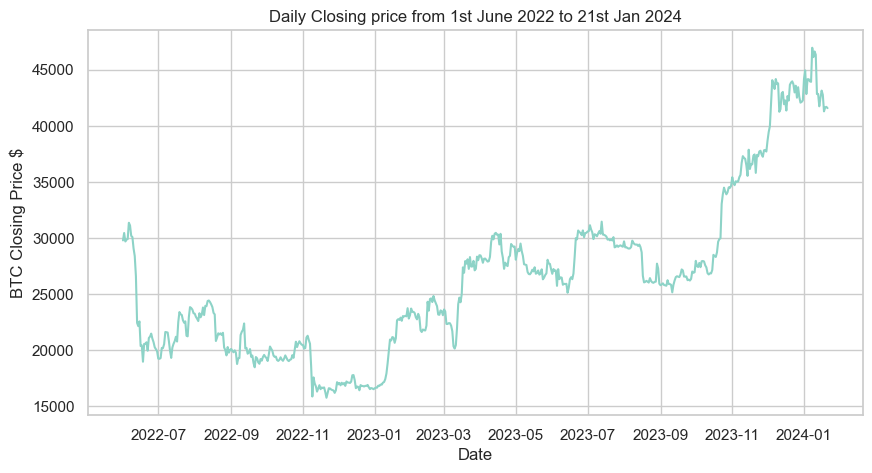

In [3]:
# plot the graph
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(df.index, df['BTC_Close_Price'])
ax.set(xlabel='Date', ylabel='BTC Closing Price $', title='Daily Closing price from 1st June 2022 to 21st Jan 2024'); 

Just looking at the graph we can see the first two assumptions, constant mean and variance, are violated.

Its a bit harder to spot seasonality on a graph, however there are no obvious periodic patterns visible.

However we can also use a statsmodels tool called seasonal_decompose to find seasonality and if it is additive or multiplicative seasonality. But that can be for another project.

#### ACF plot and PACF plot

* ACF (autocorrelation function) is the correlation of the time series with all its lags, e.g. $y_t$ with $y_{t-1}$ and $y_{t-2}$ ... to $y_{t-k}$
* PACF (partial autocorrelation function) is the partial correlation of the time series with it's lags after removing the effects of the lower order lags between them, e.g. the partial autocorrelation of $y_t$ and $y_{t-k}$ is the correlation that is not explained by their relationships with the lags $y_{t-1}$, $y_{t-2}$ ... $y_{t-k+1}$

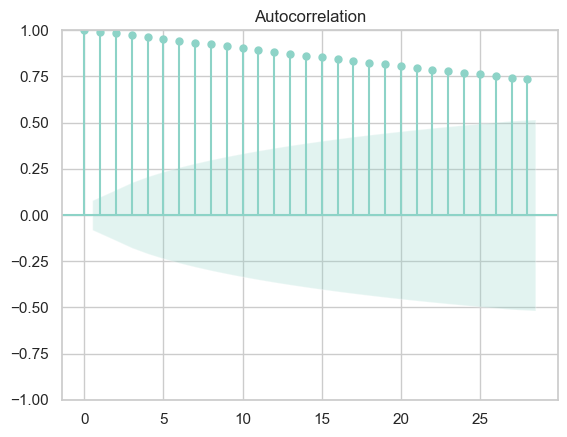

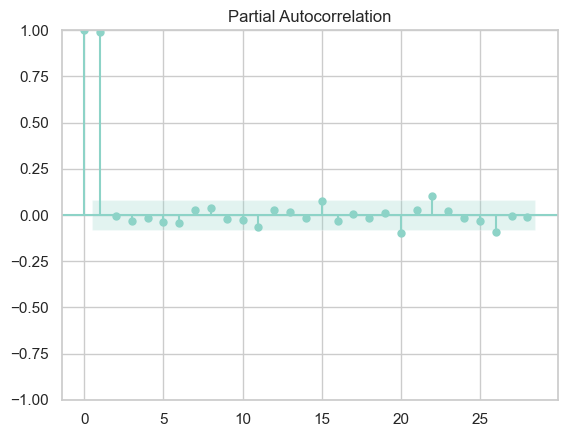

In [4]:
#plot acf plot
acf_orig = plot_acf(df)
#plot pacf plot
pacf_orig = plot_pacf(df)

The first plot (ACF) we can see is highly indicative of a non-stationary data set where we can see the correlations with the lags, are very high, positive and there is very slow decay.

And the second plot (PACF) is also typical of a non-stationary dataset which shows there is a single spike at lag 1.

These are both signs of a well known time series called a **random walk** which is not stationary.

#### ADF test

In [5]:
# augmented Dickey-Fuller unit root test function to show results

def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print('1. ADF: ', dftest[0])
    print('2. P-Value: ', dftest[1])
    print('3. Num of lags: ', dftest[2])
    print('4. Num of obs used for ADF regression & crit vals calc: ', dftest[3])
    print('5. Critical vals: ')
                     
    for key, val in dftest[4].items():
        print('\t', key, ': ', val)

In [6]:
adf_test(df['BTC_Close_Price'])

1. ADF:  -0.3073534318710822
2. P-Value:  0.9244563900945629
3. Num of lags:  0
4. Num of obs used for ADF regression & crit vals calc:  599
5. Critical vals: 
	 1% :  -3.441314181564011
	 5% :  -2.866377195394498
	 10% :  -2.5693461093196506


The ADF statistical test, tests for the null hypothesis that there is a unit root, so in other words it is non=stationary

As ADF test statistic is greater than all of the critical values (1% is with 99% certainty, 5% is with 95% certainty etc.) 

And also the P-Value is greater than 0.05 this tells us the test fails to reject the null hypothesis, or in other words the time series data is not stationary.

#### Transforming the data to make it stationary

With all the evidence above we can see we need to transform the time series to make it stationary. We have a no. of tools we can do to do this. The first option to reduce the variance would be to take the log of the time series data.

In [7]:
# take logs
df['BTC_Price_Log'] = np.log(df['BTC_Close_Price'])

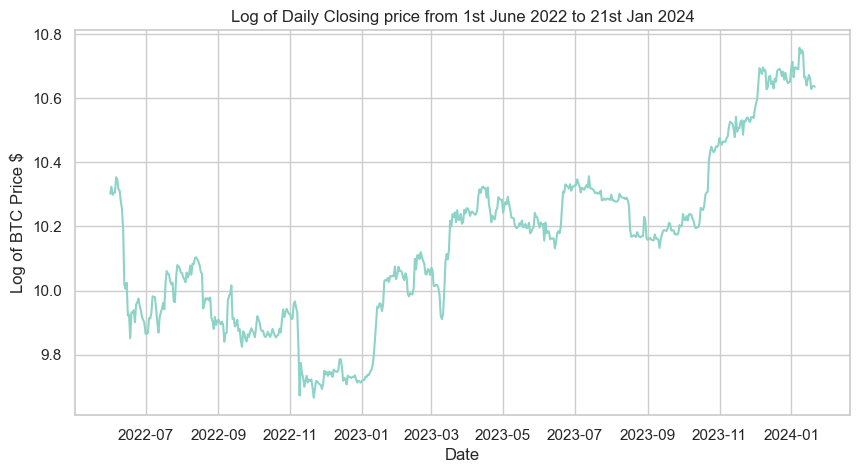

In [8]:
# plot the graph
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(df.index, df['BTC_Price_Log'])
ax.set(xlabel='Date', ylabel='Log of BTC Price $', title='Log of Daily Closing price from 1st June 2022 to 21st Jan 2024'); 

Here we can see that the variance has improved however we do not have a constant mean. 

To verify this we can also try the adf test again

In [9]:
adf_test(df['BTC_Price_Log'])

1. ADF:  -0.6441969423041018
2. P-Value:  0.8606794085379648
3. Num of lags:  0
4. Num of obs used for ADF regression & crit vals calc:  599
5. Critical vals: 
	 1% :  -3.441314181564011
	 5% :  -2.866377195394498
	 10% :  -2.5693461093196506


Another tool we can use is **differencing** the data set as explained earlier.

In [13]:
# transform to stationary - differencing
df_diff = df.diff()

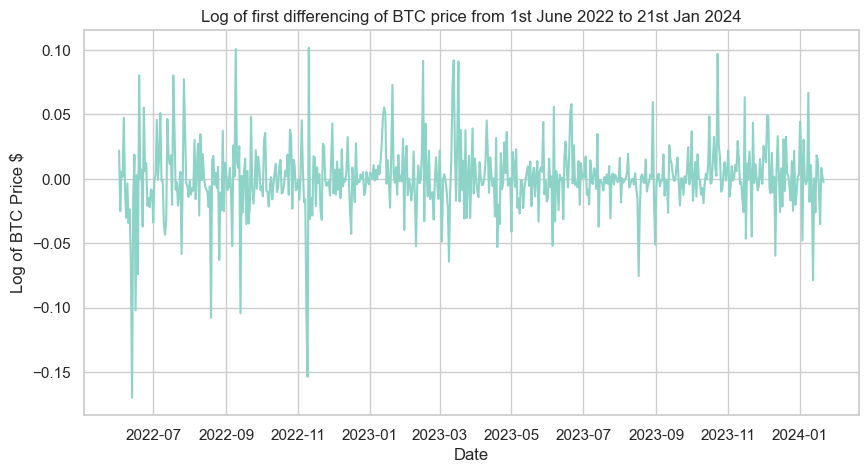

In [37]:
# plot the graph
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(df_diff.index, df_diff['BTC_Price_Log'])
ax.set(xlabel='Date', ylabel='Log of BTC Price $', title='Log of first differencing of BTC price from 1st June 2022 to 21st Jan 2024'); 

Now we can see the time series data now has a constant mean and the variance is fairly constant as well. There is no seasonality observed so this appears to be a stationary time series. However we can run the adf test again to confirm. 

In [38]:
# view the df
df_diff

,BTC_Close_Price,BTC_Price_Log
Date,,
2022-06-01,NaN,NaN
2022-06-02,657.0,0.021809
2022-06-03,-754.6,-0.025089
2022-06-04,163.4,0.005486
2022-06-05,48.7,0.001629
...,...,...
2024-01-17,-376.8,-0.008772
2024-01-18,-1476.0,-0.035121
2024-01-19,355.3,0.008568


Differencing gives us a data set which has null values, to run the adf test we have to drop the null values

In [41]:
# run adf test with nulls removed
adf_test(df_diff['BTC_Price_Log'].dropna())

1. ADF:  -24.09101054387799
2. P-Value:  0.0
3. Num of lags:  0
4. Num of obs used for ADF regression & crit vals calc:  598
5. Critical vals: 
	 1% :  -3.4413325959192393
	 5% :  -2.86638530474078
	 10% :  -2.569350430308386


Now we can accept the null hypothesis with a P-Value less than 0.05 that this is indeed a stationary time series.

If your time series data is still non-stationary you can try a 2nd order differencing, and re-run the test. 

Most of the time we should not have more than a second order differencing.

### Splitting the data

We will choose the split the data from the 1st September

In [47]:
# splitting the log of the data for visual & auto arima
train_data = df.loc['2022-06-01':'2023-08-31']['BTC_Price_Log']
test_data = df.loc['2023-09-01':'2024-01-21']['BTC_Price_Log']

# splitting the differenced data for later analysis
train_data_diff = df_diff.loc['2022-06-02':'2023-08-31']['BTC_Price_Log']
test_data_diff = df_diff.loc['2023-09-01':'2024-01-21']['BTC_Price_Log']

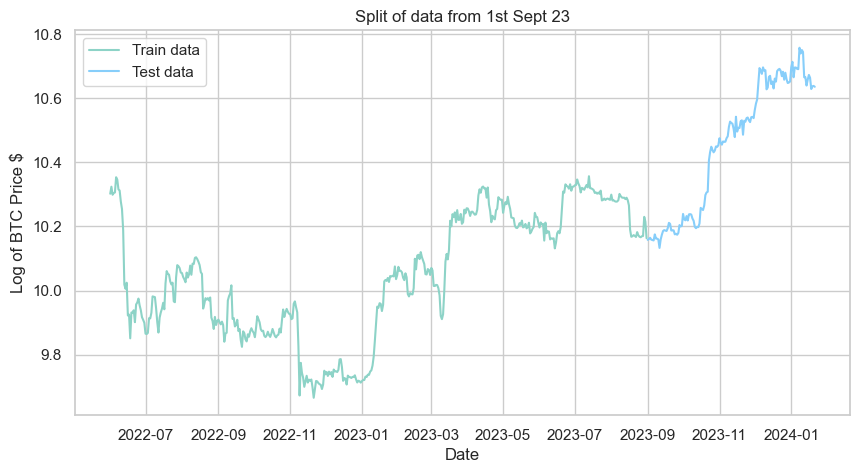

In [48]:
# view the data split 
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(train_data, label='Train data')
plt.plot(test_data, label='Test data', color='lightskyblue')
plt.legend()
ax.set(xlabel='Date', ylabel='Log of BTC Price $', title='Split of data from 1st Sept 23');

### Determining the ARIMA parameters p,d & q

At this point we know the parameter d is 1 for the first order differencing so now the model is ARIMA(p, 1, q)

Here we can use two methods to determine the parameters **p** and **q**.

* Use ACF & PACF plots
* Auto-fit the ARIMA model

#### ACF & PACF plots

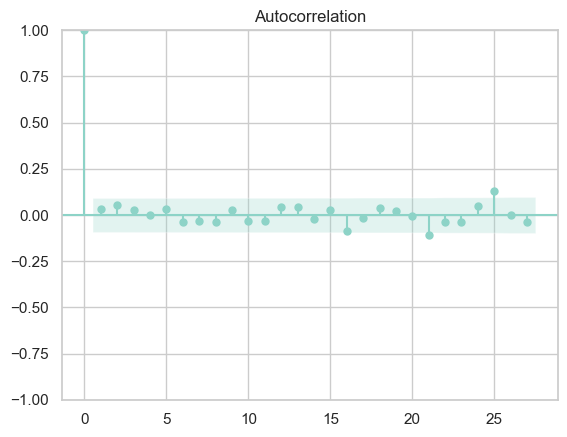

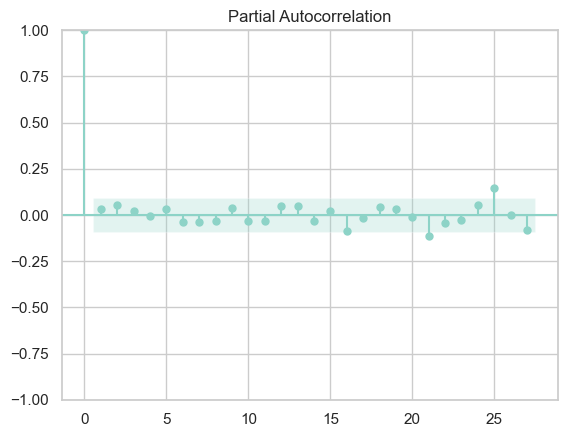

In [50]:
# plot plots
acf_diff = plot_acf(train_data_diff)
pacf_diff = plot_pacf(train_data_diff)

Based on these plot we can select the values for p & q

From the graph the shaded area in the ACF and PACF plots depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the shaded area is statistically close to zero and anything outside the blue area is statistically non-zero. 

So here we can interpret the argument for p & q as 0.

This makes our model an ARIMA(0,1,0) model

Here is a ***general rule of thumb*** when reading these plots:

If the PACF plot has a significant spike at lag p, but not beyond; the ACF plot decays more gradually. This may suggest an ARIMA(p, d, 0) model.

If the ACF plot has a significant spike at lag q, but not beyond; the PACF plot decays more gradually. This may suggest an ARIMA(0, d, q) model.

#### Auto-fit the ARIMA model

There are python packages which allow us to auto-fit ARIMA models

In [51]:
# import python pacakge
import pmdarima as pm
# run the package using the logged non-diff data, consider all models, show the steps & non seasonal models
auto_arima = pm.auto_arima(train_data, stepwise=False, trace=True, seasonal=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1948.039, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1946.458, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1945.874, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1944.081, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-1942.081, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-1940.949, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1946.507, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1945.276, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1944.117, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1942.080, Time=0.28 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-1940.081, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1945.929, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1944.086, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1941.950, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1940.135, Time=0.09

Here the auto-fit package has also suggested we use the ARIMA(0,1,0) model.

By default the auto model uses a KPSS unit root test to determine the parameter **d**.

And it uses the AIC information criteria to find the model with the lowest AIC number to determine the parameters **p** and **q**. As you can see in the printout above the model with the lowest AIC is the (0,1,0) model.

It can suggest alternative models to what your plots suggest, so the best thing is to fit both models and using cross-validation methods find which model is the best for you.

### Train the ARIMA model

After deciding the parameters of p, d & q we can fit the ARIMA model. 

Note that the order will do the differencing for us so we will fit the model without the differenced time series data (but it is still logged to reduce the variance)

In [53]:
# instatiate the model
model = ARIMA(train_data, order=(0,1,0))
# fit the model
model_fit = model.fit()
# show the summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          BTC_Price_Log   No. Observations:                  457
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 975.993
Date:                Sun, 04 Feb 2024   AIC                          -1949.986
Time:                        17:58:10   BIC                          -1945.864
Sample:                    06-01-2022   HQIC                         -1948.362
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0008    2.6e-05     31.195      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):               836.02
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Testing the model

Before using this model to make predictions, we need to make sure that the model has captured adequate information from the data.

We can check this by looking at the residuals. If the model is good, it's residuals should look like white noise.

We'll plot the residuals and their density

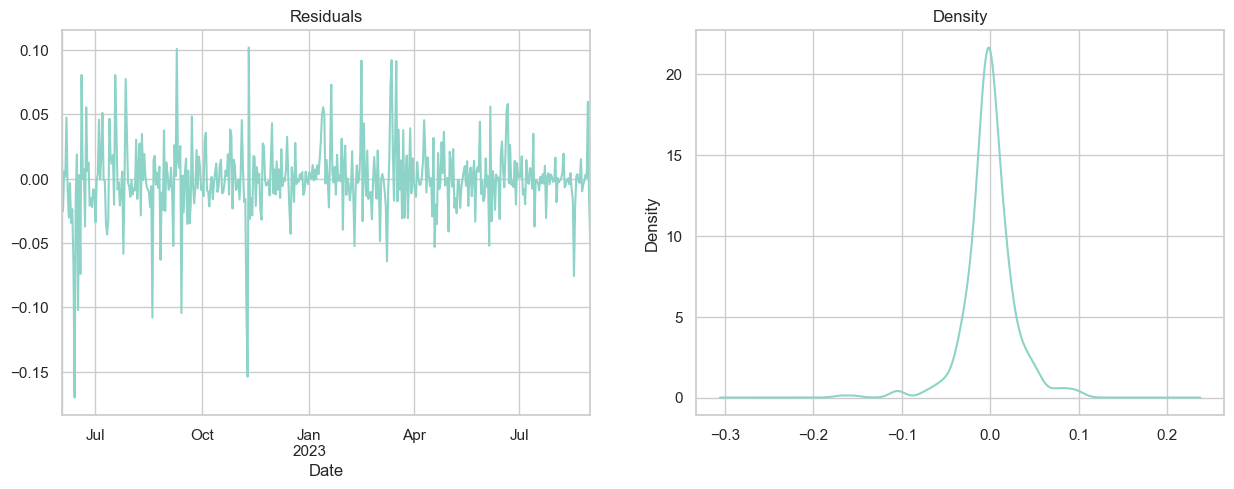

In [56]:
# create residuals var
residuals = model_fit.resid[1:]
# plot residuals and density
fig, ax = plt.subplots(1,2, figsize = (15,5))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1]);

The residuals look random in general and their density looks normally distributed with a mean of around zero.

We can also look at the ACF and PACF plots of the residuals

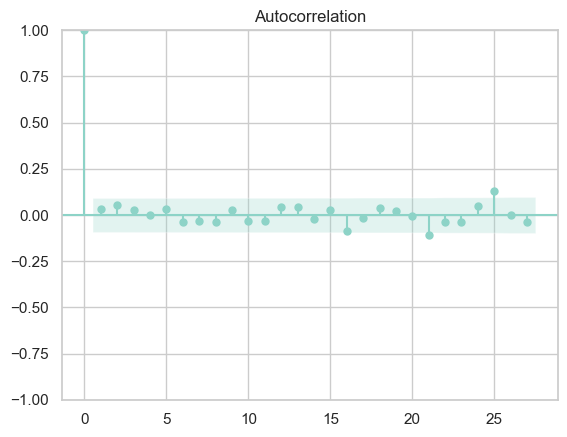

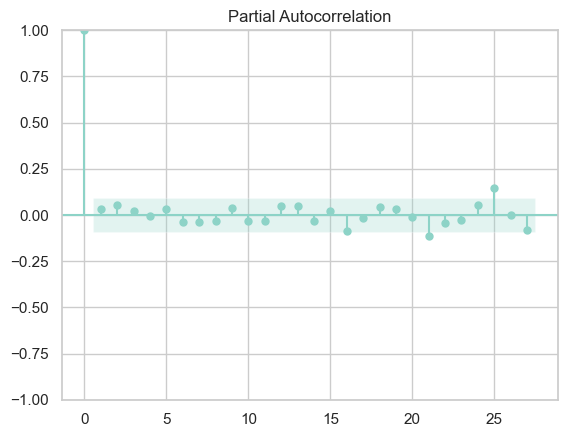

In [57]:
# plot plots
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

We can see the lower lags barely show any significant spikes, these show that the residuals are close to white noise.

We're ready to make predictions with the ARIMA(0,1,0) model with the test data.

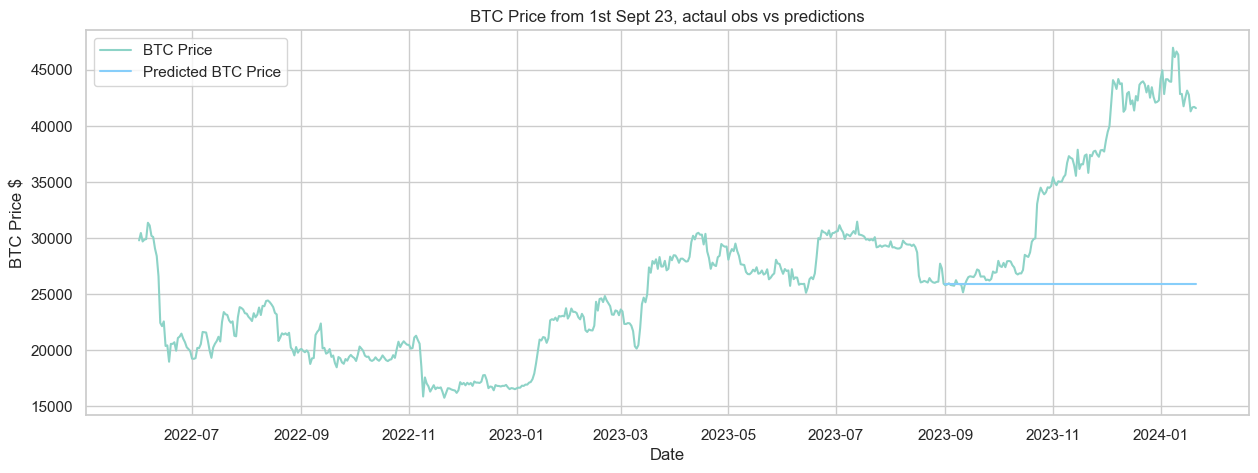

In [76]:
# make predictions on test set
forecast_test = model_fit.forecast(len(test_data))

# add to df
df['predictions'] = [None]*len(train_data) + list(forecast_test)

# view the predictions - need to convert it back from natural log using exponentional function
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(np.exp(df['BTC_Price_Log']), label='BTC Price')
plt.plot(np.exp(df['predictions']), label='Predicted BTC Price', color='lightskyblue')
#plt.axvline(x=['2023-09-14'], color='purple', linestyle='dotted')
plt.legend()
ax.set(xlabel='Date', ylabel='BTC Price $', title='BTC Price from 1st Sept 23, actaul obs vs predictions');

You can see that forecast follows the previous momentum and shows a flat trend, whilst in reality the BTC price stayed around this price for a few days and then increased in October

### Evaluating the model

We can use common metrics to evaluate this time series model prediction

* Mean Absolute Error (MAE)
* Mean Absolute Percentage Error (MAPE)
* Root Mean Squared Error (RMSE)

In [82]:
mae = mean_absolute_error(np.exp(test_data), np.exp(forecast_test))
mape = mean_absolute_percentage_error(np.exp(test_data), np.exp(forecast_test))
rmse = np.sqrt(mean_squared_error(np.exp(test_data), np.exp(forecast_test)))

print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

MAE: 9360.495804195794
MAPE: 0.23470629644819863
RMSE: 11648.990634178339


The MAE error means that on average the model predicts values that are $\pm$\\$9360 away from the actual price of BTC.

A MAPE less than 5% is considered as an indication that the forecast is acceptably accurate

The lower the value of the Root Mean Squared Error, the better the model is. A perfect model (a hypothetic model that would always predict the exact expected value) would have a Root Mean Squared Error value of 0.

So even though we managed to model the data using ARIMA, it's not a very good predictor.